In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
from lightgbm import LGBMClassifier
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
path = '/content/drive/My Drive/files_stall/'
df_train = pd.read_csv(path + 'train'+ '.csv')

In [4]:
df_train.shape

(113208, 131)

In [5]:
X_train = df_train.drop(['stalled', 'filename'], axis=1)
y_train = df_train['stalled']

In [6]:
X_train.sum(axis=0)

prediction          4808.398415
activation_0           0.000000
activation_1      308739.388507
activation_2           0.000000
activation_3      369860.478474
                      ...      
activation_123    240118.543474
activation_124    300052.937018
activation_125         0.000000
activation_126     20793.783644
activation_127         0.000000
Length: 129, dtype: float64

In [7]:
df_val = pd.read_csv(path + 'validation'+ '.csv')
df_test = pd.read_csv(path + 'test' + '.csv')

In [8]:
df_val.head()

,filename,stalled,prediction,activation_0,activation_1,activation_2,activation_3,activation_4,activation_5,activation_6,activation_7,activation_8,activation_9,activation_10,activation_11,activation_12,activation_13,activation_14,activation_15,activation_16,activation_17,activation_18,activation_19,activation_20,activation_21,activation_22,activation_23,activation_24,activation_25,activation_26,activation_27,activation_28,activation_29,activation_30,activation_31,activation_32,activation_33,activation_34,activation_35,activation_36,...,activation_88,activation_89,activation_90,activation_91,activation_92,activation_93,activation_94,activation_95,activation_96,activation_97,activation_98,activation_99,activation_100,activation_101,activation_102,activation_103,activation_104,activation_105,activation_106,activation_107,activation_108,activation_109,activation_110,activation_111,activation_112,activation_113,activation_114,activation_115,activation_116,activation_117,activation_118,activation_119,activation_120,activation_121,activation_122,activation_123,activation_124,activation_125,activation_126,activation_127
0,100083.mp4,0,0.000053,0.0,3.727803,0.0,4.587367,0.0,3.801776,0.0,0.0,0.0,0.0,0.0,0.0,2.459495,2.748972,0.0,0.0,3.890079,0.0,0.0,0.0,0.0,0.0,2.912648,0.0,0.0,0.0,0.0,0.0,1.343105,0.0,0.0,0.0,0.0,0.978110,3.949677,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.568632,0.167468,0.0,3.404782,0.0,0.0,1.763024,0.0,1.335697,4.182495,0.937476,0.0,0.0,0.0,2.801777,0.0,0.0,0.0,0.0,0.0,0.0,0.761518,5.131743,0.0,3.101275,3.965443,0.0,0.255051,0.0
1,100253.mp4,0,0.006995,0.0,1.700996,0.0,2.940012,0.0,1.423306,0.0,0.0,0.0,0.0,0.0,0.0,0.869664,1.401592,0.0,0.0,1.740105,0.0,0.0,0.0,0.0,0.0,0.944367,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.496956,2.270356,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037130,0.220549,0.0,1.670145,0.0,0.0,1.210032,0.0,0.825576,2.130529,0.590617,0.0,0.0,0.0,1.244608,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.587040,0.0,1.614533,2.245054,0.0,0.000000,0.0
2,100259.mp4,0,0.000107,0.0,3.385105,0.0,3.997331,0.0,3.863204,0.0,0.0,0.0,0.0,0.0,0.0,2.664138,2.555610,0.0,0.0,3.754363,0.0,0.0,0.0,0.0,0.0,2.902799,0.0,0.0,0.0,0.0,0.0,0.958395,0.0,0.0,0.0,0.0,0.819253,3.496679,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.465162,0.000000,0.0,3.640850,0.0,0.0,1.767450,0.0,1.327553,3.775239,0.853570,0.0,0.0,0.0,2.684865,0.0,0.0,0.0,0.0,0.0,0.0,0.710527,4.168340,0.0,2.750999,3.492872,0.0,0.265370,0.0
3,100293.mp4,0,0.047905,0.0,1.141474,0.0,1.512936,0.0,0.894223,0.0,0.0,0.0,0.0,0.0,0.0,0.642689,0.776085,0.0,0.0,0.869621,0.0,0.0,0.0,0.0,0.0,0.666537,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.268287,1.053209,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.164829,0.0,0.0,0.755921,0.0,0.540613,1.275391,0.382822,0.0,0.0,0.0,0.830435,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.277324,0.0,0.938213,1.293232,0.0,0.000000,0.0
4,100613.mp4,0,0.026031,0.0,1.427158,0.0,1.635915,0.0,1.427030,0.0,0.0,0.0,0.0,0.0,0.0,0.877463,0.875842,0.0,0.0,1.232326,0.0,0.0,0.0,0.0,0.0,0.910527,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.323826,1.176949,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.512451,0.0,0.0,0.852536,0.0,0.628363,1.518137,0.467378,0.0,0.0,0.0,1.060540,0.0,0.0,0.0,0.0,0.0,0.0,0.070848,1.465416,0.0,0.996172,1.566546,0.0,0.028755,0.0


In [9]:
X_val = df_val.drop(['stalled', 'filename'], axis=1)
y_val = df_val['stalled']
X_test = df_test.drop(['filename'], axis=1)

In [10]:
non_zero_cols = list(X_train.sum(axis=0) != 0)

In [11]:
non_zero_cols_val = list(X_val.sum(axis=0) != 0)
non_zero_cols_test = list(X_test.sum(axis=0) != 0)

In [12]:
non_zero_cols == non_zero_cols_val

True

In [13]:
X_train = X_train.iloc[:, non_zero_cols]
X_val = X_val.iloc[:, non_zero_cols]
X_test = X_test.iloc[:, non_zero_cols]

In [25]:
X_train.shape

(113208, 42)

In [15]:
y_train.sum()/y_train.shape[0]

0.015078439686241256

In [16]:
y_val.sum()/y_val.shape[0]

0.07928505957836847

In [ ]:
# X_train, X_train_val, y_train, y_train_val = train_test_split(X_train, y_train, stratify=y_train, 
#                                                     test_size=0.1, shuffle=True)

In [24]:
fit_params={"early_stopping_rounds":20, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_val,y_val)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [26]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={
    'learning_rate' : [0.01], 'n_estimators' : [400, 800, 1000, 1500, 2000, 2500, 3000],
             'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-3, 1e-1, 1, 1e1, 1e2],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20]}

In [27]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
n_HP_points_to_test = 400
#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='roc_auc', n_jobs=-1)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    n_jobs=-1,
    verbose=True)
gs.fit(X_train, y_train, **fit_params)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 21.6min finished


Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[50]	valid's auc: 0.97581


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            metric='roc_auc',
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=314, reg_alpha=0.0,
                                            reg...
                                        'n_estimators': [400, 800, 1000, 1500,
  

In [ ]:
# clf = LGBMClassifier()
# clf.set_params(**parameters)
# clf.fit(fit_params={"early_stopping_rounds":20, 
#             "eval_metric" : 'auc', 
#             "eval_set" : [(X_train_val,y_train_val)],
#             'eval_names': ['valid'],
#             #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
#             'verbose': 100,
#             'categorical_feature': 'auto'})

In [ ]:
# parameters = {'boosting_type': 'gbdt',
#  'class_weight': None,
#  'colsample_bytree': 0.48254794142574825,
#  'importance_type': 'split',
#  'learning_rate': 0.1,
#  'max_depth': -1,
#  'metric': 'roc_auc',
#  'min_child_samples': 359,
#  'min_child_weight': 100.0,
#  'min_split_gain': 0.0,
#  'n_estimators': 800,
#  'n_jobs': -1,
#  'num_leaves': 44,
#  'objective': None,
#  'random_state': 314,
#  'reg_alpha': 0.1,
#  'reg_lambda': 0,
#  'silent': True,
#  'subsample': 0.3970539022080858,
#  'subsample_for_bin': 200000,
#  'subsample_freq': 0}

In [28]:
clf = gs.best_estimator_

In [29]:
from sklearn.metrics import matthews_corrcoef, roc_auc_score

In [ ]:
from joblib import dump, load

In [ ]:

dump(clf, 'model1.sav') 

['model1.sav']

In [33]:
thrs = np.arange(0.02, 0.5, 0.01)

In [34]:
mccs = [matthews_corrcoef(y_val, clf.predict_proba(X_val)[:, 1] > thr) for thr in thrs]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [36]:
matthews_corrcoef(y_val, clf.predict_proba(X_val)[:, 1] > 0.05)

0.789965470336541

In [ ]:
mccs = [matthews_corrcoef(y_val, X_val.prediction > thr) for thr in thrs]

In [32]:
mccs

[0.686347955639376,
 0.7352674249748195,
 0.7790376555243351,
 0.789965470336541,
 0.7731226401415354,
 0.7763972461525446,
 0.765067990412978,
 0.7602419459681911,
 0.75058025029795,
 0.7409102019368272,
 0.7409102019368272,
 0.7409102019368272,
 0.7255633389737485,
 0.7167463045520444,
 0.6957639436837547,
 0.678084789537242,
 0.6648805189264455,
 0.655885399276541,
 0.6510925775967009,
 0.6466843988643632,
 0.6333040912404605,
 0.6287902516778895,
 0.6195868969289987,
 0.6195868969289987,
 0.6149846826676546,
 0.596269846689563,
 0.596269846689563,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
matthews_corrcoef(y_val, clf.predict_proba(X_val)[:, 1] > 0.04)

0.7342734414952776

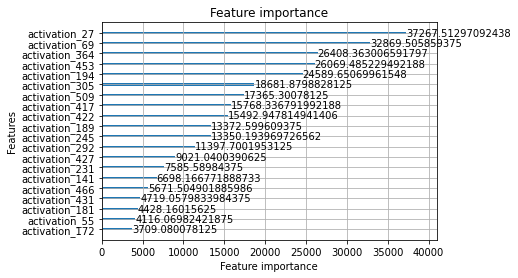

In [ ]:
from lightgbm import plot_importance
plot_importance(clf, importance_type='gain', max_num_features=20)

In [ ]:
clf.feature_importances_

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 0, 1, 0, 2, 1, 0, 0, 2, 8, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 6, 0, 0, 1, 0, 0, 0, 2,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 3, 4, 4, 3, 1, 1, 0, 3, 0, 1, 2, 6,
       6, 0, 4, 0, 0, 0, 0, 1, 3, 0, 2, 6, 2, 0, 0, 0, 1, 4, 0, 2, 4, 1,
       0, 0, 3, 0, 0, 1, 0, 0, 0, 1])

In [ ]:
roc_auc_score(y_val,  clf.predict_proba(X_val)[:, 1])

0.9521114522222254

In [50]:
predictions = clf.predict_proba(X_test)[:, 1] > 0.07
predictions = [int(i) for i in predictions]

In [57]:
sum(predictions)

774

In [ ]:
sum(df['stalled'] == predictions)

NameError: ignored

In [52]:
d = {'filename' : df_test['filename'], 'stalled' : predictions}
df = pd.DataFrame(d)

In [53]:
df.shape

(14160, 2)

In [54]:
df.head()

,filename,stalled
0,100032.mp4,0
1,100037.mp4,0
2,100139.mp4,0
3,100182.mp4,0
4,100214.mp4,0


In [56]:
df.to_csv('predictions.csv', index=False)

In [ ]:
df.head()

,filename,stalled
0,100032.mp4,0
1,100037.mp4,0
2,100139.mp4,0
3,100182.mp4,0
4,100214.mp4,0


In [ ]:
clf_new = load('model1.sav')

FileNotFoundError: ignored

In [ ]:
matthews_corrcoef(y_val, clf_new.predict_proba(X_val)[:, 1] > 0.09)

0.7322075719395355

In [ ]:
!ls

drive  predictions.csv	sample_data
